Text(0, 0.5, 'nominal rate, in %')

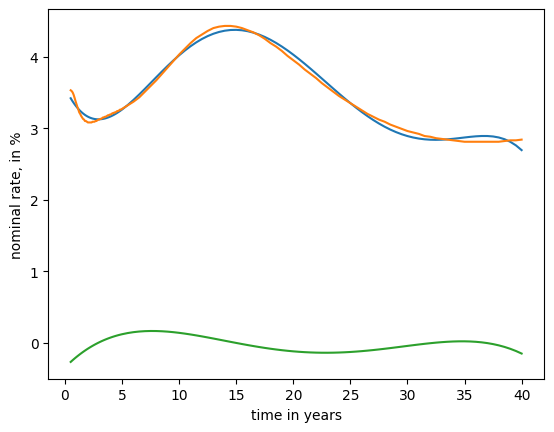

In [2]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("jan_curve.csv", delimiter=",", dtype=float)
# the jan_curve file comes from GLC Nominal month end data_2016 to present, the jan 2023 curve, which is data from the Bank of England

x = data[:,0]
y = data[:,1]

spl = interpolate.UnivariateSpline(x,y,k=5)
plt.plot(x,spl(x))
plt.plot(x,y)
plt.plot(x,spl.derivative()(x))
plt.xlabel("time in years")
plt.ylabel("nominal rate, in %")

40
[-0.09592369 -0.06244385 -0.03235271 -0.00548885  0.01830917  0.03920281
  0.0573535   0.07292267  0.08607178  0.09696226  0.10575556  0.11261311
  0.11769636  0.12116674  0.1231857   0.12391468  0.12351512  0.12214847
  0.11997615  0.11715962  0.11386031  0.11023967  0.10645913  0.10268015
  0.09906415  0.09577258  0.09296688  0.09080849  0.08945885  0.08907941
  0.08983161  0.09187688  0.09537666  0.10049241  0.10738555  0.11621753
  0.1271498   0.14034378  0.15596093  0.17416268]


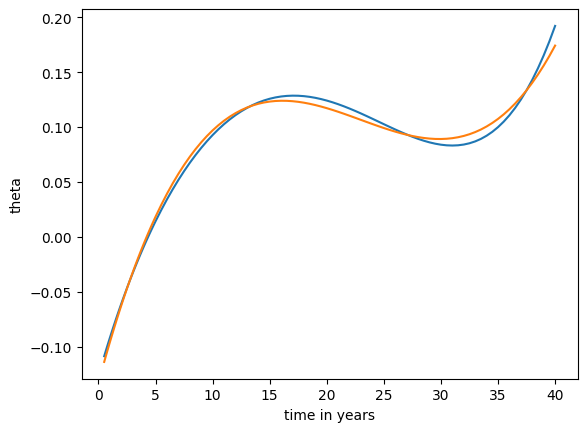

In [3]:
a = 0.1
sigma = 0.1

F = -spl.derivative()(x)
theta = -spl.derivative(n=2)(x) + a * F + sigma**2/a * (1-np.exp(-2 * a * x))

theta_spl = interpolate.UnivariateSpline(x, theta)
plt.plot(x,theta)
plt.plot(x,theta_spl(x))
plt.xlabel("time in years")
plt.ylabel("theta")

final_thetas = theta_spl(range(1,int(x[-1] + 1)))
print(len(final_thetas))
print( final_thetas)

               Month       CPI     Short    Medium      Long  Ultra-Long
Month       1.000000  0.144921 -0.598926 -0.767071 -0.847011   -0.868976
CPI         0.144921  1.000000  0.423902  0.363326  0.285336    0.248395
Short      -0.598926  0.423902  1.000000  0.945274  0.830184    0.794168
Medium     -0.767071  0.363326  0.945274  1.000000  0.959073    0.938617
Long       -0.847011  0.285336  0.830184  0.959073  1.000000    0.996863
Ultra-Long -0.868976  0.248395  0.794168  0.938617  0.996863    1.000000


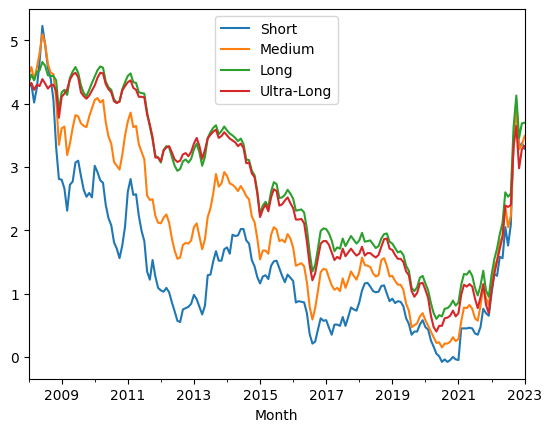

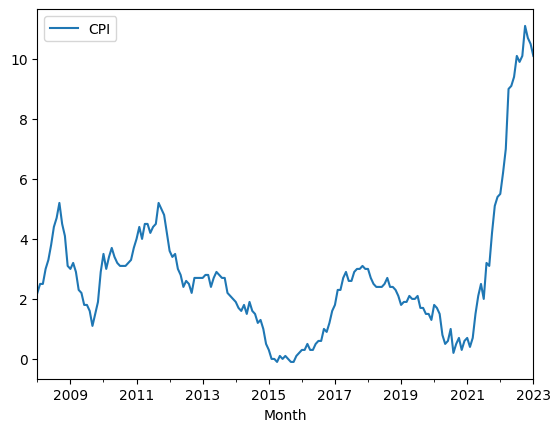

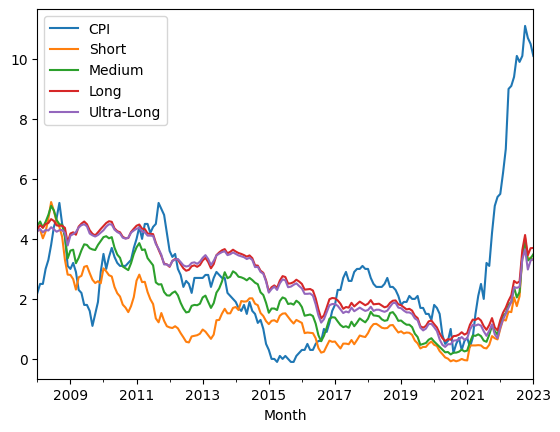

In [10]:
import pandas as pd
def strip_spaces(df):
    return df.replace(r"^ +| +$", r"", regex=True).rename(columns=lambda x: x.strip())

cpi_df = pd.read_csv('../../Data/cpi/cpi_all_1989-2022.csv')
cpi_df = strip_spaces(cpi_df)

gilt_df = pd.read_csv('../../Data/Historical_Average_Daily_Conventional_Gilt_Yields.csv')
gilt_df = strip_spaces(gilt_df)
## load both data sets and find a way to make the timesteps the same 
## then find the pmcc of them both and use that in my model
cpi_df['Month'] = pd.to_datetime(cpi_df['Month'], format="%Y %b")

gilt_df['Month'] = pd.to_datetime(gilt_df['Month'], format="%b-%Y")
cpi_df = cpi_df[~(cpi_df['Month'] < gilt_df.iloc[0]['Month'])]
cpi_df = cpi_df[~(cpi_df['Month'] < '01/01/2008')]

gilt_df['Long'] = gilt_df['Long'].str.rstrip('%').astype('float')
gilt_df['Short'] = gilt_df['Short'].str.rstrip('%').astype('float')
gilt_df['Medium'] = gilt_df['Medium'].str.rstrip('%').astype('float')
gilt_df['Ultra-Long'] = gilt_df['Ultra-Long'].str.rstrip('%').astype('float')
gilt_df = gilt_df[~(gilt_df['Month'] < '01/01/2008')]

gilt_df.plot.line(x="Month")
# gilt_df.plot.line("Month","Short")
# gilt_df.plot("Month","Medium")
# gilt_df.plot("Month","Ultra-Long")
cpi_df.plot("Month","CPI")
df = pd.merge(cpi_df, gilt_df, how="outer", on="Month")
df.plot.line(x="Month")
print(df.corr(method="pearson"))